In [ ]:
!pip install livelossplot==0.5.1 --quiet

import gc
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import cv2 as cv
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
from skimage.transform import resize 
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset

from PIL import Image

from matplotlib import pyplot as plt

from livelossplot import PlotLosses

from google.colab import drive
import os
from os import listdir
from sys import getsizeof
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class h5DatasetSlice(Dataset):

    def __init__(self, file_path, func=None, portion=(0, 1)):
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + "DIML.h5", "r")
        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        portion = [int(k*len(self.rgb_dbs)) for k in portion]

        self.rgb_dbs = self.rgb_dbs[portion[0] : portion[1]]
        self.depth_dbs = self.depth_dbs[portion[0] : portion[1]]
        
        self.totens = transforms.ToTensor()

    def __getitem__(self, index):
        
        rgb = self.file[self.rgb_dbs[index]][:]
        depth = self.file[self.depth_dbs[index]][:]

        if self.func:
            rgb, depth = self.func(rgb, depth)
        else:
            rgb = self.totens(rgb)
            depth = self.totens(depth.astype(np.float64) / 65535.0)
            
        return rgb, depth

    
    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))

class SkipUpconv(nn.Module):
    def __init__(self, in_channels, out_channels, activ=nn.LeakyReLU(0.2)):
        super(SkipUpconv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activ = activ
        self.norm = nn.BatchNorm2d(out_channels)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels = out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )

    def forward(self, small, big):
        scaled = F.interpolate(small, size=big.shape[2:], mode='bilinear', 
                               align_corners=True)
        out = self.norm(self.activ(self.conv(torch.cat((scaled, big), dim=1))))

        return F.interpolate(out, scale_factor=2, mode='bilinear', 
                             align_corners=True)

class SkipUpconv2(nn.Module):
    def __init__(self, in_channels, out_channels, activ=nn.LeakyReLU(0.2)):
        super(SkipUpconv2, self).__init__()

        mid_channels = (in_channels + out_channels) // 2
        self.activ = activ
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels = mid_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=mid_channels,
            out_channels = out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )

    def forward(self, small, big):
        #print(small.shape, big.shape)
        scaled = F.interpolate(small, size=big.shape[2:], mode='bilinear', 
                               align_corners=True)
        x = self.activ(self.conv1(torch.cat((scaled, big), dim=1)))
        x = self.activ(self.conv2(x))

        return F.interpolate(x, scale_factor=2, mode='bilinear', 
                             align_corners=True)
        
class SkipUpconv3(nn.Module):
    def __init__(self, in_channels, out_channels, activ=nn.LeakyReLU(0.2)):
        super(SkipUpconv3, self).__init__()

        '''
        calculates intermediate number of channels (spread out evenly) so that 
        there is a smooth transition between input and output channels
        '''
        mid_channels_1 = in_channels*2//3 + out_channels*1//3
        mid_channels_2 = in_channels*1//3 + out_channels*2//3
        self.activ = activ
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels = mid_channels_1,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=mid_channels_1,
            out_channels = mid_channels_2,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        self.conv3 = nn.Conv2d(
            in_channels=mid_channels_2,
            out_channels = out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )

    '''
    takes two layers of different sizes and outputs a layer twice as big as the 
    largest input. Parameter order matters!!!!
    '''
    def forward(self, small, big):
        '''
        scales the smallest layer to match the larger one so they can be 
        concatenated
        '''
        scaled = F.interpolate(small, size=big.shape[2:], mode='bilinear', 
                               align_corners=True)
        '''
        concatenate the scaled small layer with the big layer, and pass them 
        through three convolutions with decreasing number of channels
        '''
        x = self.activ(self.conv1(torch.cat((scaled, big), dim=1)))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))

        '''
        scale output by factor of 2 and return it
        '''
        return F.interpolate(x, scale_factor=2, mode='bilinear', 
                             align_corners=True)

def vecinfo(vec):
    totens = transforms.ToTensor()
    try:
        vec = totens(vec)
    except:
        pass
    print("min: {}, max: {}, mean: {}".format(
        torch.min(vec),
        torch.max(vec),
        torch.mean(vec)
    ))

def alter(rgb, depth):

    totens = transforms.ToTensor()

    rgb, depth = random_rotate((rgb, depth), max_angle=15, fill=1)
    rgb, depth = random_hflip((rgb, depth))
    rgb = TF.center_crop(rgb, (400, 533))
    depth = TF.center_crop(depth, (400, 533))
    rgb = resize(np.array(rgb), (225, 300))
    depth = resize(np.array(depth), (225, 300))
    rgb, depth = random_crop((np.array(rgb, dtype='float64'), np.array(depth, dtype='float64')), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def random_crop(data, size):
    rgb, depth = data
    h, w = rgb.shape[:2]
    new_h, new_w = size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    rgb = rgb[top: top + new_h,
              left: left + new_w]
    depth = depth[top: top + new_h,
                  left: left + new_w]
    
    return rgb, depth

def random_rotate(data, max_angle, resample=False, expand=False, 
                  center=None, fill=None):
    rgb, depth = data
    rgb = Image.fromarray(rgb)
    depth = Image.fromarray(depth)
    angle = np.random.uniform(-max_angle, max_angle)
    return (TF.rotate(rgb, angle, resample, expand, center, fill),
            TF.rotate(depth, angle, resample, expand, center, fill))

def random_hflip(data, p=0.5):
    rgb, depth = data

    if torch.rand(1) < p:
        return TF.hflip(rgb), TF.hflip(depth)
    
    return rgb, depth

def alter_val(rgb, depth):

    totens = transforms.ToTensor()

    rgb = TF.center_crop(Image.fromarray(rgb), (400, 533))
    depth = TF.center_crop(Image.fromarray(depth), (400, 533))
    rgb = resize(np.array(rgb), (224, 224))
    depth = resize(np.array(depth), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    depth = transforms.Normalize(0,0.1217)(depth)

    return rgb, depth

def load_dataset(file_path, batch_size, ratios=(.7, .15, .15), shuffle=True):
    train_data = h5DatasetSlice(file_path=file_path, func=alter, 
                                portion=(0, ratios[0]))
    val_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                portion=(ratios[0], ratios[0]+ratios[1]))
    test_data = h5DatasetSlice(file_path=file_path, func=alter_val,
                                portion=(ratios[0]+ratios[1], 1))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)

    return train_loader, val_loader, test_loader

def valid_loss(model, criterion, val_loader, index):

    model.eval()

    with torch.no_grad():

        for i, (rgb, depth) in enumerate(val_loader, \
                                         index % (len(val_loader) - 1)):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            pred = model(rgb.float())
            del rgb

            return torch.sqrt(criterion(depth.squeeze(), pred.squeeze())).item()

def train(model, batch_size=16, lr=0.01, num_epochs=1, ratios=(.8, .1, .1),
          load_pretrained=False, checkpoint_name='skipautoenc.pth'):

    if not os.path.exists(os.path.dirname(checkpoint_filepath + checkpoint_name)):
      print("Checkpoint folder not found. Creating new folder")
      os.makedirs(os.path.dirname(checkpoint_filepath + checkpoint_name))
    else:
      print("Checkpoint folder found.")

    if load_pretrained:
      checkpoint = torch.load(checkpoint_filepath + checkpoint_name)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      print("Resuming training from epoch",checkpoint['epoch'],"\nLoss:", checkpoint['loss'])

    #plotlosses = PlotLosses(groups={'Training': ['t loss'], 'Validation': ['v loss']})
    plotlosses = PlotLosses(groups={'Loss': ['train', 'val']})

    print("loading data...")
    train_loader, val_loader = load_dataset(
        file_path=darie_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]
    print("data loading complete")

    t_loss = np.zeros(len(train_loader) * num_epochs)
    v_loss = np.zeros(len(train_loader) * num_epochs)

    torch.manual_seed(69)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, \
                                        factor=0.25, patience=15, verbose=True)

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader):

            model.train()

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):

                pred = model(rgb.float())
                del rgb

                loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze()))

                gc.collect()
            
                loss.backward()
                optimizer.step()

            val_loss = valid_loss(model, nn.MSELoss(), val_loader, i)

            scheduler.step(loss.item())

            plotlosses.update({
                'train': loss.item(),
                'val': val_loss
            })
            #plotlosses.send()

            t_loss[epoch * len(train_loader) + i] = loss.item()
            v_loss[epoch * len(train_loader) + i] = val_loss

            torch.save({
                'epoch': epoch,
                'loss': loss.item(),
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, checkpoint_filepath + checkpoint_name)

            '''
            plt.imshow(depth.cpu().detach().numpy()[0].squeeze(), cmap='inferno')
            plt.show()
            plt.imshow(pred.cpu().detach().numpy()[0].squeeze(), cmap='inferno')
            plt.show()
            '''
            del depth, pred

            if torch.cuda.is_available():
                torch.cuda.synchronize()

    np.savetxt('train_loss.csv', t_loss)
    np.savetxt('val_loss.csv', v_loss)
    

darie_path = "/content/gdrive/My Drive/APS360_Project/Data/"
checkpoint_filepath = "/content/gdrive/My Drive/APS360_Project/Checkpoints/"

In [ ]:
class SkipEncoder4(nn.Module):
    def __init__(self, channels=(640, 250, 100, 50)):
        super(SkipEncoder4, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        self.dec2 = SkipUpconv(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        x1 = self.dec1(features[19])
        x2 = self.dec2(x1, features[14])
        x3 = self.dec3(x2, features[7])
        x4 = self.dec4(x3, features[4])
        x5 = self.dec5(x4, features[2])

        return self.sig(x5)

class SkipEncoder5(nn.Module):
    def __init__(self, channels=(640, 300, 150, 50)):
        super(SkipEncoder5, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()

        self.norm1 = nn.BatchNorm2d(channels[1])
        self.norm2 = nn.BatchNorm2d(channels[3])

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        self.dec2 = SkipUpconv2(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv2(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv2(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv2(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        x1 = self.dec1(features[19])
        x2 = self.norm1(self.dec2(x1, features[14]))
        x3 = self.dec3(x2, features[7])
        x4 = self.norm2(self.dec4(x3, features[4]))
        x5 = self.dec5(x4, features[2])

        print(x0.shape, x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)

        return self.sig(x5)

class SkipEncoder6(nn.Module):
    def __init__(self, channels=(640, 300, 150, 50)):
        super(SkipEncoder6, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()

        self.norm1 = nn.BatchNorm2d(channels[1])
        self.norm2 = nn.BatchNorm2d(channels[3])

        # 1280 is the number of output channels from the last mobilenet layer
        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        '''
        the numbers added to the input channels are the number of channels in 
        the mobilenet layers that will be concatenated later. Those have to be 
        changed if you want to do the connections differently. See forward 
        function comment for how to print feature shapes.
        '''
        self.dec2 = SkipUpconv3(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv3(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv3(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv3(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        '''
        passes the rgb image into mobilenet and appends the output of each layer
        into the features list. This saves the progress of the feature maps
        as they progress through the network. Any of those outputs can be fed 
        into dec1, dec2, etc. which are objects of the SkipUpconv class. 
        Basically this allows us to have skip connections from inside the 
        pretrained model encoder going into the custom layers in the decoder.
        Use this code to better understand the features list and how to properly 
        index it to extract the outputs you want:

        for feature in features:
            print(feature.shape)
        
        note: put this after the for loop below
        '''
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        '''
        introduce skip connections from the encoder into the decoder portion of
        the model. This allows the trainable decoder to have access to less 
        processed and less abstract versions of the input image, which makes it 
        better at capturing geometric details. There are also two normalizations 
        spread out between the upconvolutions.
        '''
        x1 = self.dec1(features[19])
        x2 = self.norm1(self.dec2(x1, features[14]))
        x3 = self.dec3(x2, features[7])
        x4 = self.norm2(self.dec4(x3, features[4]))
        x5 = self.dec5(x4, features[2])

        return self.sig(x5)

class SkipEncoder7(nn.Module):
    def __init__(self, channels=(640, 300, 150, 50)):
        super(SkipEncoder7, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True).cuda()

        self.norm1 = nn.BatchNorm2d(channels[1])
        self.norm2 = nn.BatchNorm2d(channels[3])

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        self.dec2 = SkipUpconv2(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv2(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv2(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv2(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        x1 = self.dec1(features[19])
        x2 = self.norm1(self.dec2(x1, features[14]))
        x3 = self.dec3(x2, features[7])
        x4 = self.norm2(self.dec4(x3, features[4]))
        x5 = self.dec5(x4, features[2])

        return self.sig(x5)

# Skip Encoder 4

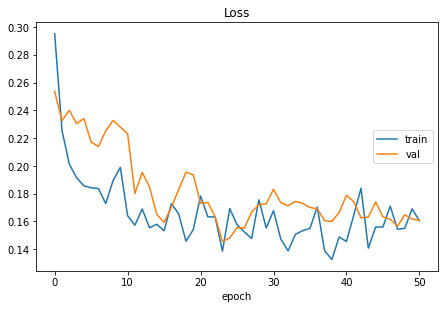

Loss
	train            	 (min:    0.133, max:    0.295, cur:    0.161)
	val              	 (min:    0.146, max:    0.254, cur:    0.161)


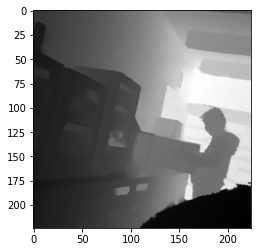

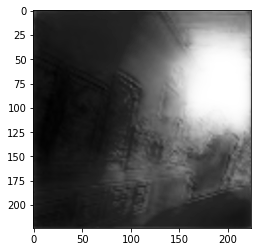

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc4 = SkipEncoder4()

print(sum(p.numel() for p in skipenc4.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    skipenc4.cuda()

train(skipenc4, batch_size=32, lr=2e-4, num_epochs=5, ratios=(.8, .15, .05))

# Skip Encoder 5

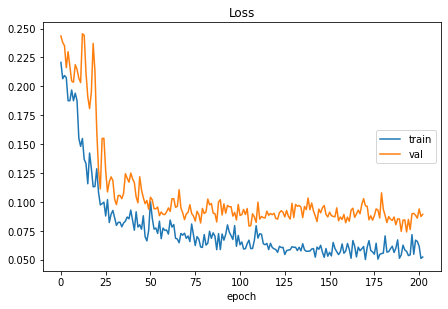

Loss
	train            	 (min:    0.050, max:    0.221, cur:    0.052)
	val              	 (min:    0.074, max:    0.246, cur:    0.089)


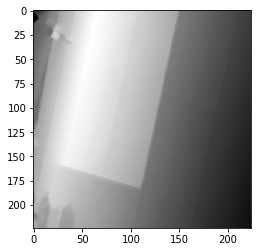

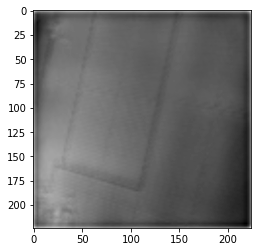

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc5 = SkipEncoder5()

print(sum(p.numel() for p in skipenc5.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    skipenc5.cuda()

# 0.055, 0.082 (good looking predictions), patience 10
#train(skipenc5, batch_size=32, lr=2e-4, num_epochs=5, ratios=(.8, .15, .05))
train(skipenc5, batch_size=32, lr=3e-4, num_epochs=5, ratios=(.8, .15, .05))

# Skip Encoder 6

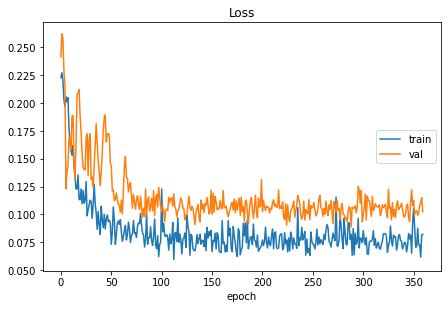

Loss
	train            	 (min:    0.059, max:    0.227, cur:    0.082)
	val              	 (min:    0.089, max:    0.262, cur:    0.102)


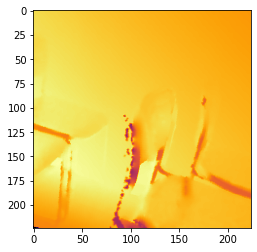

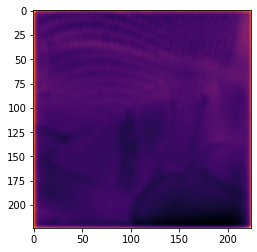

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc6 = SkipEncoder6()

print(sum(p.numel() for p in skipenc6.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    skipenc6.cuda()

#TRAIN FOR AROUND 300 BATCHES OR SO

train(skipenc6, batch_size=16, lr=4e-4, num_epochs=2, ratios=(.8, .15, .05), 
      checkpoint_name='skipautoencTEST.pth')

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

skipenc5 = SkipEncoder5()

print(sum(p.numel() for p in skipenc5.parameters()))

if torch.cuda.is_available():
    print("GPU available")
    skipenc5.cuda()

#TRAIN FOR AROUND 300 BATCHES OR SO

train(skipenc5, batch_size=32, lr=7e-4, num_epochs=4, ratios=(.8, .15, .05), 
      checkpoint_name='skipautoencTEST.pth')

17001398
GPU available
Checkpoint folder found.
loading data...
2888 542 181
data loading complete
torch.Size([32, 3, 224, 224]) torch.Size([32, 640, 7, 7]) torch.Size([32, 300, 28, 28]) torch.Size([32, 150, 56, 56]) torch.Size([32, 50, 112, 112]) torch.Size([32, 1, 224, 224])


KeyboardInterrupt: ignored

# Result Checking

In [ ]:
train_loader, val_loader, test_loader = load_dataset(
        file_path=darie_path,
        batch_size=64,
        ratios=(.7, .15, .15),
        shuffle=True
        )

skipenc5 = SkipEncoder5().cuda()

checkpoint_name = 'skipautoenc3.pth'

checkpoint = torch.load(checkpoint_filepath + checkpoint_name)
skipenc5.load_state_dict(checkpoint['model_state_dict'])

2527 542 542


<All keys matched successfully>

torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
min: 0.0, max: 0.996078431372549, mean: 0.4878391848971859
min: 0.11547706792816273, max: 0.24554723860149985, mean: 0.20432976737024333
min: 0.1028919592499733, max: 0.7684752345085144, mean: 0.3457413613796234


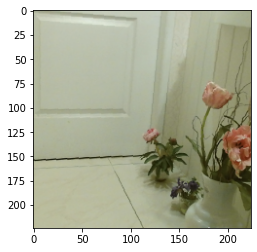

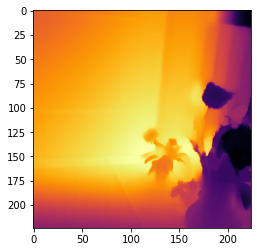

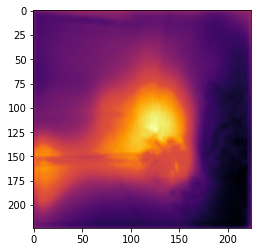

In [ ]:
for i, (rgb, depth) in enumerate(train_loader):

    print(rgb.shape, depth.shape)

    rgb1 = np.moveaxis(np.array(rgb[0]), 0, -1)
    depth1 = np.moveaxis(np.array(depth[0]), 0, -1).squeeze()

    #print(rgb1)

    transform = transforms.ToTensor()

    pred = np.array(skipenc5(transform(rgb1).cuda().float().unsqueeze(0)).detach().cpu()).squeeze()

    #print(depth1, pred)
    #print(torch.max(depth1), torch.min(depth1), torch.mean(depth1))
    vecinfo(rgb)
    vecinfo(depth1)
    vecinfo(pred)

    plt.imshow(rgb1)
    plt.show()
    plt.imshow(depth1, cmap='inferno')
    plt.show()
    plt.imshow(pred, cmap='inferno')
    plt.show()
    break